# K-Nearest Neighbors (KNN): A Guided Tour with the Iris Dataset

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Scikit-learn imports
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_decision_regions

# Set plot styles
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 🌸 Section 1: The "Flower Identification" Algorithm

### General Concept: The Neighborhood Analogy

The K-Nearest Neighbors (KNN) algorithm is built on the simple, intuitive idea that **"you are known by the company you keep."** It's a **supervised learning** algorithm that makes predictions about a new, unknown data point by looking at the data points that are most similar to it—its "nearest neighbors."

To classify a new point, KNN finds the `K` most similar, labeled points in the training data and holds an "election." The new point is assigned the class that is most common among its neighbors. 

### Connecting to Iris: The Neighborhood Botanist

Let's apply this to a classic problem: identifying iris flower species. Our task is to predict a flower's species (the class) based on four features: sepal length, sepal width, petal length, and petal width. In this context, our analogy becomes: **"If an unknown flower looks like a group of known Setosa irises, it's probably a Setosa too."** The algorithm will classify a new iris by finding the labeled flowers in our dataset that have the most similar measurements.

### General Concept: Why is KNN "Lazy"?

KNN is a classic **non-parametric** and **instance-based** (or "lazy learning") algorithm.

- **Non-parametric**: This means the algorithm makes no assumptions about the underlying data distribution (e.g., that the data follows a line or a specific curve).
- **Lazy Learning**: This is a key trait. Unlike many algorithms that have an intensive "training" phase where they learn a function, KNN does almost nothing during training. Its training phase consists of simply memorizing the entire training dataset. All the real work is deferred until a prediction is requested.

### Connecting to Iris: Memorizing the Garden

In the context of our Iris problem, the "lazy" training phase means the KNN algorithm simply stores the measurements and species of all the iris flowers in our training set. It doesn't try to find a general rule or formula from the data beforehand. It only does work when we present it with a new, unlabeled flower to identify.

## 📐 Section 2: The Core Mechanics of "Nearness"

### General Concept: Distance Metrics

To find the "nearest" neighbors, we must have a formal way to measure the distance or similarity between two data points. This is done using distance metrics. The choice of metric is fundamental to the algorithm. For two generic data points, `p` and `q`, in an `n`-dimensional space:

**1. Euclidean Distance (L2 Norm):** This is the most common metric, representing the straight-line "as the crow flies" distance between two points.
$$ d(p, q) = \sqrt{\sum_{i=1}^{n} (p_i - q_i)^2} $$

**2. Manhattan Distance (L1 Norm):** This measures the "city block" distance—the sum of the absolute differences of the coordinates.
$$ d(p, q) = \sum_{i=1}^{n} |p_i - q_i| $$

### Connecting to Iris: Measuring Distance Between Flowers

Now let's apply these formulas to our Iris dataset. We'll measure the distance between two specific flowers based on their four features. First, let's load the data and select our sample irises.

In [4]:
# Load the dataset and create a DataFrame
iris = load_iris()
X = iris.data
y = iris.target
iris_df = pd.DataFrame(X, columns=iris.feature_names)
iris_df['species'] = y
iris_df['species_name'] = iris_df['species'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

# Let's pick two sample irises for our calculation
iris_A_data = iris_df.loc[0]  # First Iris (a Setosa)
iris_B_data = iris_df.loc[55] # A Versicolor
iris_A = iris_A_data[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']].values
iris_B = iris_B_data[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']].values

print("Iris A (Setosa): [sepal_len=5.1, sepal_wid=3.5, petal_len=1.4, petal_wid=0.2]")
print("Iris B (Versicolor): [sepal_len=5.7, sepal_wid=2.8, petal_len=4.5, petal_wid=1.3]")

Iris A (Setosa): [sepal_len=5.1, sepal_wid=3.5, petal_len=1.4, petal_wid=0.2]
Iris B (Versicolor): [sepal_len=5.7, sepal_wid=2.8, petal_len=4.5, petal_wid=1.3]


**Euclidean Distance Example:**

$$ d(A, B) = \sqrt{(5.1-5.7)^2 + (3.5-2.8)^2 + (1.4-4.5)^2 + (0.2-1.3)^2} $$

In [5]:
# Manually calculate Euclidean distance
euclidean_distance = np.sqrt(np.sum((iris_A - iris_B)**2))
print(f"The calculated Euclidean distance is: {euclidean_distance:.4f}")

The calculated Euclidean distance is: 3.4161


**Manhattan Distance Example:**

$$ d(A, B) = |5.1-5.7| + |3.5-2.8| + |1.4-4.5| + |0.2-1.3| $$

In [6]:
# Manually calculate Manhattan distance
manhattan_distance = np.sum(np.abs(iris_A - iris_B))
print(f"The calculated Manhattan distance is: {manhattan_distance:.4f}")

The calculated Manhattan distance is: 5.5000


## ⚙️ Section 3: The KNN Algorithm in Action

### General Concept: The Prediction Process

The prediction process for any new data point follows a clear, step-by-step sequence:

1.  **Input**: Receive a new, unclassified data point (`x_new`), the entire training dataset (`X_train`, `y_train`), a chosen value for `K`, and a distance metric.
2.  **Calculate All Distances**: Compute the distance from `x_new` to **every single point** in `X_train` using the chosen metric.
3.  **Identify the K-Nearest Neighbors**: Sort these distances in ascending order and find the `K` points from the training data that are closest to `x_new`.
4.  **Make a Prediction (Vote or Average)**:
    - **For Classification**: Perform a **majority vote**. The class that appears most frequently among the `K` neighbors becomes the prediction.
    - **For Regression**: Calculate the **average (mean)** of the target values of the `K` neighbors.
5.  **Weighted Voting (Advanced)**: Optionally, give more influence to closer neighbors. The vote of each neighbor can be weighted by the inverse of its distance ($1/distance$).


### Connecting to Iris: Classifying a New Flower

Let's walk through this process with a concrete example from our Iris dataset.

1.  **Input**: We have a **new, unclassified iris flower**, `iris_new`, with measurements `[6.0, 2.9, 4.5, 1.5]`. We'll use our full set of 150 labeled irises as the training data, choose `K=5`, and use the Euclidean distance metric.

2.  **Calculate All Distances**: The algorithm calculates the Euclidean distance from `iris_new` to **every one of the 150 irises** in our dataset.

3.  **Identify the 5-Nearest Neighbors**: It sorts the 150 distances and finds the 5 flowers that are closest to `iris_new`.

4.  **Make a Prediction (Majority Vote)**: Let's imagine the species of the 5 closest neighbors are found to be: `[Versicolor, Versicolor, Virginica, Versicolor, Setosa]`.
    - The algorithm holds an election: **Versicolor** has 3 votes, **Virginica** has 1 vote, and **Setosa** has 1 vote.
    - The majority winner is **Versicolor**. The model predicts that our `iris_new` is an Iris Versicolor.

## 👨‍💻 Section 4: Building KNN from Scratch

### The Goal: Translating Theory to Code

To fully grasp the algorithm, we will now translate the general prediction steps from Section 3 into a Python class. We will build a simple KNN classifier from scratch to predict the species of an iris.


In [7]:
class SimpleKNNClassifier:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        # The "lazy" training step: just memorize the data
        self.X_train = X
        self.y_train = y

    def predict(self, X_test):
        predictions = [self._predict_single(x) for x in X_test]
        return np.array(predictions)

    def _predict_single(self, x):
        # 1. Calculate Euclidean distances to all training points
        distances = [np.sqrt(np.sum((x_train - x)**2)) for x_train in self.X_train]
        
        # 2. Get the indices of the k-nearest neighbors
        k_indices = np.argsort(distances)[:self.k]
        
        # 3. Get the labels of these neighbors
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        # 4. Perform a majority vote
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

### Applying our Classifier to the Iris Data

Now, we will test our generic classifier on the specific Iris dataset. Let's use it to predict the species for the same `iris_new` from our Section 3 walkthrough.

In [8]:
# Prepare the data (we'll use the full dataset as training for this example)
X_train = iris.data
y_train = iris.target
target_names = iris.target_names

# Our new, unlabeled iris
iris_new = np.array([[6.0, 2.9, 4.5, 1.5]])

# Instantiate and use our custom KNN with K=5
custom_knn = SimpleKNNClassifier(k=5)
custom_knn.fit(X_train, y_train)
prediction_index = custom_knn.predict(iris_new)
predicted_species = target_names[prediction_index][0]

print(f"The new iris has features: {iris_new[0]}")
print(f"Our from-scratch model predicts the species is: '{predicted_species}'")

The new iris has features: [6.  2.9 4.5 1.5]
Our from-scratch model predicts the species is: 'versicolor'


## 🛠️ Section 5: Crucial Practical Considerations

### General Concept: Feature Scaling

**Feature scaling is a mandatory preprocessing step for almost any distance-based algorithm.** Because KNN calculates distance between points, features with larger scales (e.g., a salary ranging from 50,000 to 200,000) will completely dominate and overwhelm features with smaller scales (e.g., years of experience from 1 to 20). This skews the distance calculation, leading to poor model performance. We must scale our features so they all contribute fairly.

### Connecting to Iris: Why Scaling Matters for Flowers

Let's see why this is critical for the Iris dataset. `petal length` (1.0-6.9cm) has a much larger range than `petal width` (0.1-2.5cm). Without scaling, the `petal length` feature would have a much larger impact on the distance calculation than `petal width`. To prevent this bias, we use `StandardScaler` to give all features a mean of 0 and a standard deviation of 1.

In [9]:
# Split data first to avoid data leakage from the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Instantiate the scaler
scaler = StandardScaler()

# Fit the scaler ONLY on the training data, then transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Original Training Data (first 3 rows):\n", X_train[:3])
print("\nScaled Training Data (first 3 rows):\n", np.round(X_train_scaled[:3], 4))

Original Training Data (first 3 rows):
 [[5.1 2.5 3.  1.1]
 [6.2 2.2 4.5 1.5]
 [5.1 3.8 1.5 0.3]]

Scaled Training Data (first 3 rows):
 [[-0.9005 -1.2202 -0.442  -0.1366]
 [ 0.3804 -1.8796  0.4028  0.3803]
 [-0.9005  1.6368 -1.2868 -1.1704]]


### General Concept: The Curse of Dimensionality

This critical concept describes how algorithm performance can degrade as the number of features (dimensions) increases. In high-dimensional spaces, data becomes very sparse—the volume of the space grows so fast that the data points become increasingly isolated. The distance between any two points becomes less meaningful, as all points tend to be far from each other.

### Connecting to Iris: Keeping Dimensions Low

Our Iris dataset has only 4 features, making it low-dimensional, which is an ideal scenario for KNN. However, imagine if we had 100 features for each flower (e.g., chlorophyll levels, soil pH, humidity, etc.). In that 100-dimensional space, the concept of a 'close' neighbor would become unreliable, and KNN's performance would suffer greatly. This is why KNN is generally not suitable for high-dimensional data problems.

## 🧪 Section 6: Hyperparameter Tuning & Evaluation

### General Concept: The Hyperparameter `K` and the Bias-Variance Tradeoff

The choice of `K` is the most important hyperparameter for a KNN model. It controls the model's complexity and is a crucial knob for managing the **bias-variance tradeoff**.
- **Small `K` (e.g., K=1)**: The model has **low bias** but **high variance**. The decision boundary is highly flexible and closely follows the training data, making it sensitive to noise and prone to **overfitting**.
- **Large `K`**: The model has **high bias** but **low variance**. The decision boundary is very smooth. If `K` is too large, the model becomes overly simple and will **underfit**, missing the local patterns in the data.

### Connecting to Iris: Visualizing the Tradeoff

We can clearly visualize this tradeoff using the Iris dataset. By plotting the decision boundaries on two of its features (petal length and width), we can see how a small `K=1` creates a jagged, overfit boundary that traces individual data points, while a large `K=50` creates an overly smooth, underfit boundary that misclassifies many flowers.

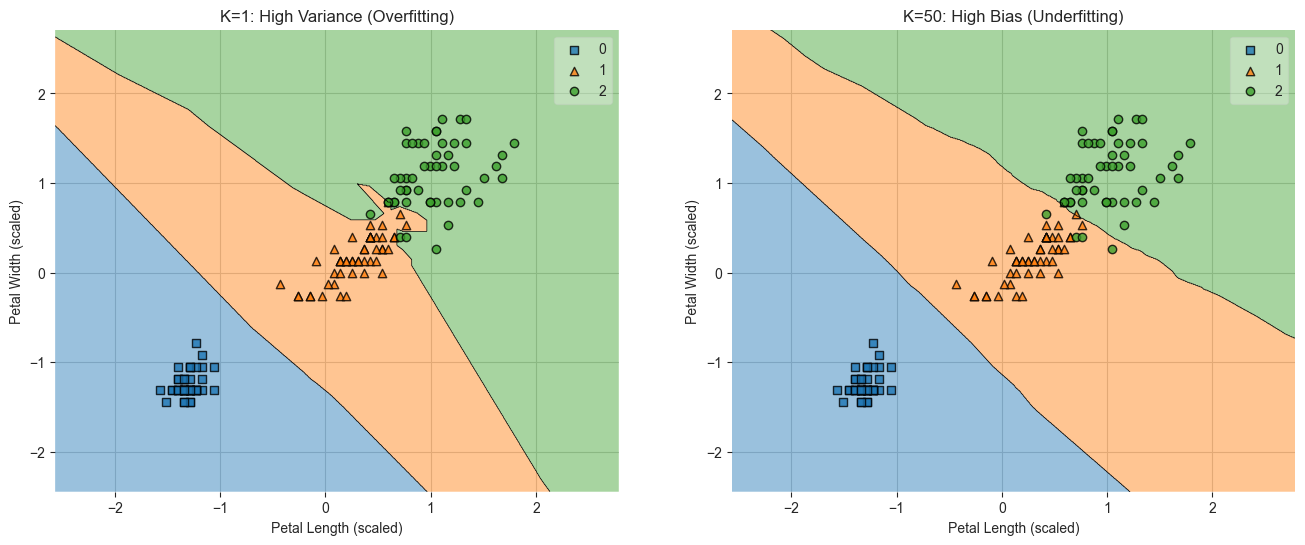

In [10]:
# We will use two features for visualization: petal length and petal width
X_vis = X[:, [2, 3]]
y_vis = y

# Models with different K
knn_k1 = KNeighborsClassifier(n_neighbors=1)
knn_k50 = KNeighborsClassifier(n_neighbors=50)

scaler_vis = StandardScaler()
X_vis_scaled = scaler_vis.fit_transform(X_vis)

knn_k1.fit(X_vis_scaled, y_vis)
knn_k50.fit(X_vis_scaled, y_vis)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_decision_regions(X_vis_scaled, y_vis, clf=knn_k1, ax=axes[0])
axes[0].set_title('K=1: High Variance (Overfitting)')
axes[0].set_xlabel('Petal Length (scaled)')
axes[0].set_ylabel('Petal Width (scaled)')

plot_decision_regions(X_vis_scaled, y_vis, clf=knn_k50, ax=axes[1])
axes[1].set_title('K=50: High Bias (Underfitting)')
axes[1].set_xlabel('Petal Length (scaled)')
axes[1].set_ylabel('Petal Width (scaled)')

plt.show()

### General Concept: The Elbow Method

A useful heuristic for finding a good starting value for `K` is the Elbow Method. The process involves plotting the model's error rate for a range of `K` values. Typically, the error rate will decrease as `K` increases, but then flatten out. The "elbow" of the curve—the point of diminishing returns—is often a good choice for the optimal `K`.

### Connecting to Iris: Finding the Elbow

Let's apply this method to our Iris classification task. We will loop through `K` values from 1 to 40, train a model for each, and plot the resulting error rate on the test set. We'll look for the 'elbow' point where the error rate stops improving significantly.

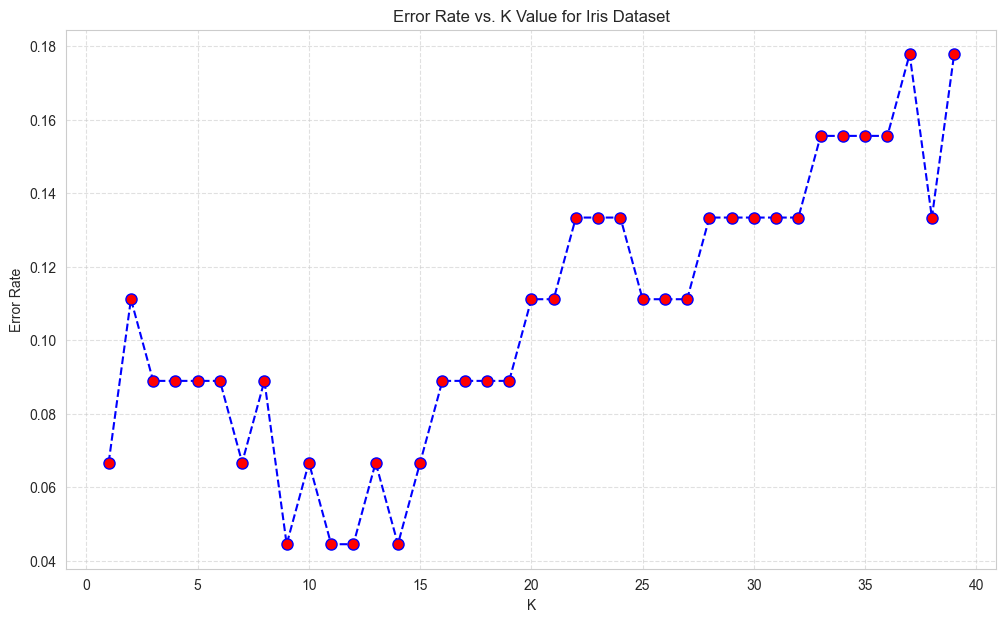

In [11]:
error_rate = []
k_range = range(1, 40)

for k in k_range:
    # Remember to use the scaled data!
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    pred_k = knn.predict(X_test_scaled)
    error_rate.append(np.mean(pred_k != y_test)) # 1 - accuracy

# Plotting the error rate
plt.figure(figsize=(12, 7))
plt.plot(k_range, error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=8)
plt.title('Error Rate vs. K Value for Iris Dataset')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### General Concept: Cross-Validation with Grid Search

A more robust and standard approach for hyperparameter tuning is k-fold cross-validation, which can be automated using Scikit-learn's `GridSearchCV`. This tool systematically tests a predefined "grid" of hyperparameters (e.g., different values for `K`, `weights`, and `metric`) and uses cross-validation to find the combination that performs best on average.

### Connecting to Iris: Finding the Best Hyperparameters

Now, we will use `GridSearchCV` on our scaled Iris training data to systematically search for the best combination of `n_neighbors`, `weights`, and `metric`.

In [12]:
# Define the parameter grid to search
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(
    KNeighborsClassifier(), 
    param_grid, 
    cv=5, # 5-fold cross-validation
    scoring='accuracy', 
    verbose=1, 
    n_jobs=-1 # Use all available CPU cores
)

# Fit the grid search to our scaled training data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and best score
print(f"\nBest Parameters Found: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 120 candidates, totalling 600 fits

Best Parameters Found: {'metric': 'euclidean', 'n_neighbors': 14, 'weights': 'uniform'}
Best Cross-Validation Accuracy: 0.9714


## ✅ Section 7: Conclusion & Summary

In this notebook, we explored K-Nearest Neighbors, a simple yet powerful instance-based learning algorithm. By applying it to the classic Iris dataset, we moved from abstract theory to concrete practice, seeing firsthand how to implement the algorithm, the importance of scaling, and the process of tuning `K` to build a robust model.

### Summary of Strengths & Weaknesses

**Strengths 👍:**
- **Simple & Intuitive**: The core concept is easy to understand, and its effectiveness was clear on the Iris data's distinct clusters.
- **No "Training" Phase**: The model is ready as soon as the data is stored, which we saw requires no complex optimization.
- **Flexible Decision Boundary**: It's non-parametric, allowing it to capture the non-linear separation between the iris species.

**Weaknesses 👎:**
- **Computationally Expensive at Prediction**: While fast for 150 irises, prediction time grows linearly with the size of the training set, making it slow for large-scale problems.
- **High Memory Usage**: It must store the entire dataset, which is a significant drawback for very large datasets.
- **Sensitive to Dimensionality**: Its performance would have suffered if our iris dataset included many more (especially irrelevant) features.